In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix, scale, get_Phi, get_max_lambda, calculate_weight_path
from sgpi.plot import *

from sgpi import model
from sgpi.learner import SGRegressionLearner

import pandas as pd
import pysgpp as sg; sg.omp_set_num_threads(4)

from scipy.sparse.linalg import LinearOperator
import re

# Artificial dataset
Two highly correlated variable.

In [2]:
size = 10
np.random.seed(42)
cov = np.matrix([[1, 0.95], [0.95, 1]])
X = np.matrix(np.random.multivariate_normal(mean=[0,0], cov=cov,size=size))
eps = np.random.normal(scale=0.25)
x1 = 0.5*(np.sin(X[:,0]) + 1)
x2 = 0.5*(np.sin(X[:,1]) + 1)
y = 3 * np.arcsin(x1) - 1.5*np.arcsin(x2) + eps
df = pd.DataFrame(np.hstack((x1, x2, y)), columns=['x1', 'x2', 'y'])

In [3]:
df.corr()

,x1,x2,y
x1,1.000000,0.931552,0.950717
x2,0.931552,1.000000,0.794801
y,0.950717,0.794801,1.000000


In [4]:
estimator.fit(*get_xy(df))

NameError: name 'estimator' is not defined

In [ ]:
-estimator.score(*get_xy(df))

In [2]:
def get_estimator(grid_config, X, y, l1_ratio, reg_type):
    level = grid_config.level
    dim = X.shape[1]
    grid = sg.Grid.createModLinearGrid(dim)
    gen = grid.getGenerator()
    gen.regular(level)
    
    Phi = get_Phi(grid, X)
    max_lambda = get_max_lambda(Phi, y, grid.getSize(), X.shape[0], l1_ratio)
    regularization_config = model.RegularizationConfig(type=reg_type, exponent_base=1, lambda_reg=max_lambda, l1_ratio=l1_ratio)
    adaptivity_config = model.AdaptivityConfig(num_refinements=0, no_points=0, treshold=0.0, percent=0.0)
    solv_type = sg.SLESolverType_FISTA
    solver_config = model.SolverConfig(type=solv_type, max_iterations=400, epsilon=0, threshold=10e-8)
    final_solver_config = solver_config
    estimator = SGRegressionLearner(grid_config, regularization_config, solver_config,
                                    final_solver_config, adaptivity_config)

    return estimator, Phi, max_lambda, grid

In [5]:
df = get_dataset('concrete')
X_train, y_train = get_xy(df)

level = 5
l1_ratio = 1.0
reg_type = sg.RegularizationType_ElasticNet

grid_config = model.GridConfig(type=sg.GridType_ModLinear, T=0.0, level=level)

In [ ]:
estimator, Phi, max_lambda, grid = get_estimator(grid_config, X_train, y_train, l1_ratio, reg_type)
#df = calculate_weight_path(estimator, X_train, y_train, max_lambda, verbose=1, num_lambdas=5)

In [8]:
estimator

SGRegressionLearner(adaptivity_config=<sgpi.model.AdaptivityConfig object at 0x7f8928a3b750>,
          final_solver_config=<sgpi.model.SolverConfig object at 0x7f8928bb9e90>,
          grid_config=<sgpi.model.GridConfig object at 0x7f895cc2ce90>,
          interactions=None,
          regularization_config=<sgpi.model.RegularizationConfig object at 0x7f8928a3bf10>,
          solver_config=<sgpi.model.SolverConfig object at 0x7f8928bb9e90>)

In [9]:
df_rec = pd.read_csv('../experiments/path-f1-l2-lasso.csv', index_col=0)

In [78]:
# https://stackoverflow.com/questions/4836710/does-python-have-a-built-in-function-for-string-natural-sort/16090640#16090640
# With added sort_key (needed for legend sorting.)
def natural_sort(l, key=None): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    sort_key = lambda k: [ convert(c) for c in re.split('([0-9]+)', k) ] 
    if key is None:
        alphanum_key = sort_key
    else:
        alphanum_key = lambda k: sort_key(key(k))
    return sorted(l, key = alphanum_key)

def get_selected_terms(group):
    return len([i for i in group if i != 0.0])

def plot_weight_path(weight_df, num_estimators = None, cmap='Dark2', fig=None, ax=None):
    # Hic sunt dracones
    lambda_grid = weight_df.columns.values.astype(float)
    max_weights = weight_df.abs().max(axis=1).groupby(weight_df.index).sum()
    num_groups = np.count_nonzero(max_weights)
    colors = sns.color_palette(cmap, num_groups)
    size = figsize(1.2)[0]*2
    if ax is None:
        fig, ax = plt.subplots(figsize=(size, size/3))
    curColor = 0
    for group, data in weight_df.groupby(weight_df.index):
        if max_weights[group] != 0.0:
            c = colors[curColor]
            curColor = curColor + 1
        else:
            c = 'grey'
        for i in range(0,len(data)):
            d = data.values[i]
            ax.semilogx(lambda_grid, d, c=c, linewidth=3)
        ax.plot([], [], label=group, c=c)
    lambdas = [np.min(lambda_grid), np.percentile(lambda_grid, 25), np.median(lambda_grid), np.percentile(lambda_grid, 75), np.max(lambda_grid)]
    ax.set_xticks(lambdas)
    ax.set_xticklabels(lambdas)
    ax.set_xlabel(r"$\displaystyle{\lambda}$")
    ax.set_ylabel("Weights")
    ax.set_xlim(left=lambda_grid[-1], right=lambda_grid[0])
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*natural_sort(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,1))
    ax.grid(axis='y', linestyle='dashed')

    sns.despine(fig, ax)  
    return fig, ax

# TODO: https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
def plot_heatmaps(df):
    gb = df.groupby(df.index)
    selected = gb.aggregate(get_selected_terms).T
    selected = selected.reindex_axis(natural_sort(selected.columns), axis=1)
    norms = gb.aggregate(lambda g : np.linalg.norm(g)).T
    norms = norms.reindex_axis(natural_sort(norms.columns), axis=1)
    size = figsize(1.2)[0]*2
    fig, axs = plt.subplots(2,1, figsize=(size, 0.5*size/np.sqrt(2)), sharex=True)
    cbar_kws = {'label': 'Number of Grid Points',
               'boundaries': np.arange(0, 7),
               'pad': 0, 'shrink':0.9}
    sns.heatmap(selected, square=True, ax=axs[0], cbar_kws=cbar_kws, cmap='Greens')
    cbar_kws = {'label': 'Group Norm', 'pad': 0, 'shrink':0.9}
    sns.heatmap(norms, square=True, ax=axs[1], cbar_kws=cbar_kws, cmap='Reds')
    for ax in axs:
       # ax.set_xlabel('Modelled Interaction')
        ax.set_ylabel('Regularization $\lambda$')
    axs[1].set_xlabel('Modelled Interaction')
    return fig, axs

def plot_barplots(df):
    fig, axs = plt.subplots(2,1,)
    gb = df.groupby(df.index)
    sns.barplot(data=gb.aggregate(get_selected_terms).T, ax=axs[0])
    sns.barplot(data=gb.aggregate(lambda g : np.linalg.norm(g)).T, ax=axs[1])
    sns.despine(fig)
    return fig, axs

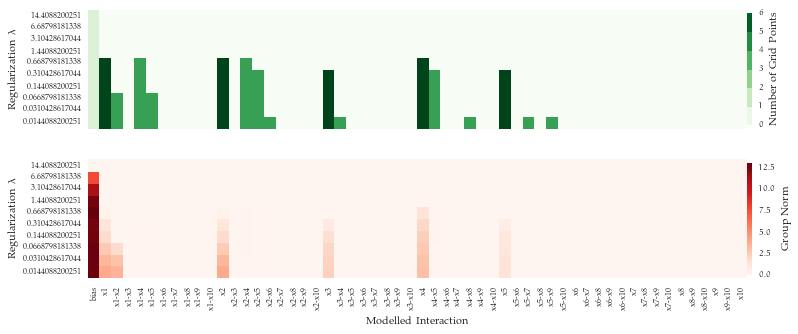

In [81]:
df_grp_heat = pd.read_csv("../experiments/path-f1-l3-grp.csv", index_col=0)
fig, ax = plot_heatmaps(df_grp_heat)
#fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig("../writing/thesis/figures/heatmap_grp.pdf", bbox_inches='tight')

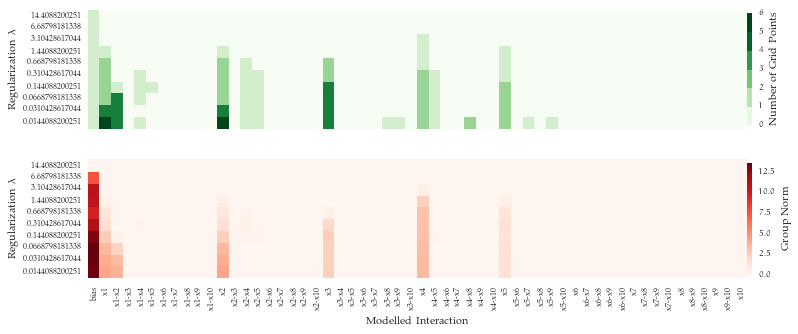

In [82]:
df_lasso_heat = pd.read_csv("../experiments/path-f1-l3-lasso.csv", index_col=0)
fig, ax = plot_heatmaps(df_lasso_heat)
#fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig("../writing/thesis/figures/heatmap_lasso.pdf", bbox_inches='tight')

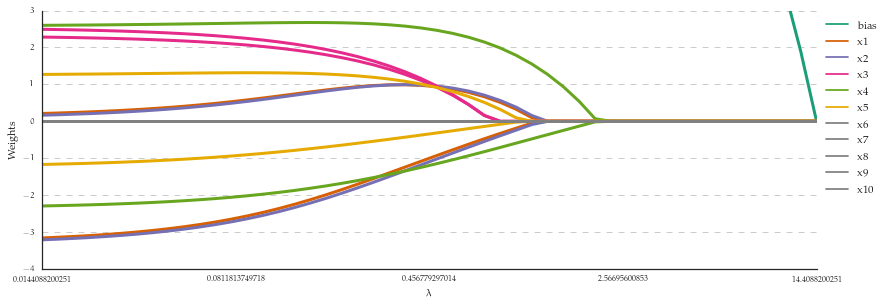

In [53]:
df_grp_path = pd.read_csv("../experiments/path-f1-l2-grp.csv", index_col=0)
fig, ax = plot_weight_path(df_grp_path, cmap='Dark2')
ax.set_ylim(bottom=-4, top=3)
fig.savefig("../writing/thesis/figures/path_grp.pdf", bbox='tight', bbox_inches='tight')

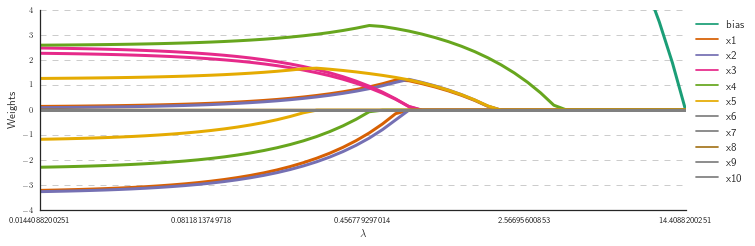

In [24]:
df_lasso_path = pd.read_csv("../experiments/path-f1-l2-lasso.csv", index_col=0)
fig, ax = plot_weight_path(df_lasso_path, num_estimators=1)
ax.set_ylim(bottom=-4, top=4)
fig.savefig("../writing/thesis/figures/path_lasso.pdf", bbox='tight', bbox_inches='tight')

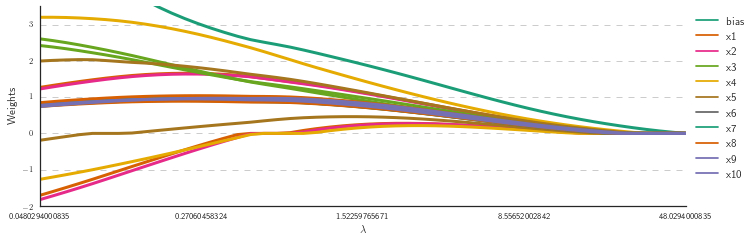

In [25]:
df_en_path = pd.read_csv("../experiments/path-f1-l2-en.csv", index_col=0)
fig, ax = plot_weight_path(df_en_path, cmap='Dark2')
ax.set_ylim(bottom=-2, top=3.5)
fig.savefig("../writing/thesis/figures/path_en.pdf", bbox='tight', bbox_inches='tight')
#ax.set_xlim(8, 16)

In [8]:
fig, ax = plt.subplots(nrows = Phi.shape[1] / 7, ncols=7, figsize=(15,5), sharex=True, sharey=True)
for i in range(0, Phi.shape[1]):
    row = i / 7
    col = i % 7
    ax[row][col].scatter(Phi[:,i], y_train)
    ax[row][col].set_axis_off()
    #ax[row][col].set_xlim(0, 2.0)
fig.set_figwidth(150)
fig.set_figheight(50)
sns.despine(fig)

NameError: name 'Phi' is not defined

In [9]:
df_en_path 

,48.0294000835,41.714080247,36.2291531401,31.4654315635,27.3280851929,23.7347528129,20.6139027712,17.9034090142,15.5493143577,13.5047563737,...,0.170815615517,0.148355304891,0.128848269654,0.111906187683,0.0971917967954,0.0844121809522,0.0733129392401,0.0636731215732,0.0553008302886,0.0480294000835
bias,2.164136e-16,0.031896,0.068446,0.1103,0.157511,0.209031,0.264162,0.323707,0.388266,0.457568,...,3.482958,3.666743,3.869232,4.086369,4.321072,4.576832,4.862975,5.176520,5.513239,5.872525
x1,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.008511,0.032078,...,-0.679554,-0.795535,-0.912220,-1.030159,-1.148105,-1.265134,-1.379317,-1.491174,-1.600961,-1.708390
x1,0.000000e+00,0.000000,0.000000,0.0000,0.008795,0.039584,0.072675,0.108528,0.147588,0.189867,...,1.640845,1.621598,1.595570,1.561926,1.522014,1.476939,1.429048,1.377950,1.323588,1.266578
x2,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.011807,0.035533,...,-0.789193,-0.908380,-1.027669,-1.147804,-1.267422,-1.385518,-1.499911,-1.611294,-1.720074,-1.825997
x2,0.000000e+00,0.000000,0.000000,0.0000,0.004428,0.034627,0.067093,0.102281,0.140675,0.182224,...,1.615296,1.593977,1.565793,1.530189,1.488426,1.441554,1.391641,1.338505,1.282254,1.223525
x3,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000,0.022870,0.052631,0.084988,0.119845,...,1.977724,2.062269,2.145437,2.224652,2.299823,2.370597,2.438286,2.500932,2.557050,2.606201
x3,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.020144,0.050645,0.083678,0.119537,0.158097,...,1.892215,1.962943,2.032782,2.099365,2.162661,2.222369,2.279742,2.332924,2.380498,2.422030
x4,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015853,...,-0.621031,-0.700228,-0.777268,-0.853605,-0.928457,-1.001392,-1.070523,-1.137205,-1.202479,-1.266538
x4,0.000000e+00,0.000000,0.000000,0.0000,0.028937,0.062773,0.099386,0.139306,0.182958,0.230523,...,2.952899,3.011294,3.061868,3.103236,3.136223,3.161463,3.180954,3.193959,3.200123,3.199862
x5,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.009399,0.035235,0.062601,...,0.081737,0.046563,0.010714,0.000000,0.000000,0.000000,-0.035049,-0.085991,-0.137699,-0.190185


In [162]:
s['x10']

0.0

In [150]:
np.count_nonzero(s.sum())

6

In [151]:
s.sum()

bias    14.406526
x1       4.151622
x10      0.000000
x2       4.204984
x3       4.774833
x4       4.971169
x5       2.485734
x6       0.000000
x7       0.000000
x8       0.000000
x9       0.000000
dtype: float64

In [9]:
sorted([0, 100, 50], reverse=True)

[100, 50, 0]